<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# _*Working with Different Backends*_ 

In this tutorial, we will first describe the various [backends](#backends) available in Qiskit and how to find out more information about each of them, then we will explore how Qiskit allows you to compile and run the same quantum circuit on different backends with different topology. 

The latest version of this notebook is available on https://github.com/qiskit/qiskit-tutorial.

***
### Contributors
Jay Gambetta, Joe Hellmers, Anna Phan, Ali Javadi

## Qiskit's Backend Architecture<a id='backends'></a>

At the core of Qiskit is the ability to access different backends to run your quantum programs. These backends are real devices, online simulators, and local simulators. As we continue to increase the flexibility of Qiskit we expect there to be many different backends. These will include new hardware with different number of qubits, connectivity, different gate sets, and simulators with different properties. 

Current devices can be found on the [devices page](https://quantumexperience.ng.bluemix.net/qx/devices) of the IBM Q Experience.

The simulators are grouped by functionality:
* QASM simulators - these simulate a quantum circuit and predict the outcomes of a quantum experiment. 
* Unitary simulators – predicts the unitary of a quantum circuit without measurement and conditional operations.
* Statevector simulators - predicts the statevector output resulting from the evolution of the zero state through a quantum circuit, without measurement and conditional operations.

The three important parts defining Qiskit's backends are: the `provider`, the `backend`, and the `job` object. 

* The *provider* is responsible for providing access to some backends. The two main providers supported by Qiskit are Aer and IBMQ. Qiskit is also extensible to other 3rd party providers. By importing Aer, you get access to its simulators which run locally on your computer. By importing IBMQ and loading your credentials, you get access to the devices and online simulators provided by IBMQ.
* The *backend* is responsible for running a `Qobj` (compiled program), and reporting a result.
* The *job* is the result of an execution. Jobs in Qiskit are launched asynchronously, meaning you get control of your Python program after you launch an execution, with a handle to the job that was submitted. You may then continue to inquire about the status of a job, or once complete, see the result from a job.

In [1]:
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, compile
from qiskit.wrapper.jupyter import *
from qiskit.tools.visualization import plot_histogram
from pprint import pprint

### The Aer and IBMQ providers

A provider must support one basic method: `backends()` and `run()`. The 1st will return a list of backend objects available from that provider. The 2nd will run a Qobj and return a job handle. 

```
Aer.backends() - list all the backends available from Aer
IBMQ.backends() - list all the backends available from IBMQ
```

In [2]:
Aer.backends()

[<QasmSimulator('qasm_simulator') from Aer()>,
 <QasmSimulatorPy('qasm_simulator_py') from Aer()>,
 <StatevectorSimulator('statevector_simulator') from Aer()>,
 <StatevectorSimulatorPy('statevector_simulator_py') from Aer()>,
 <UnitarySimulator('unitary_simulator') from Aer()>,
 <CliffordSimulator('clifford_simulator') from Aer()>]

To work with the IBMQ provider, you need to load your accounts into your current working session. You can do so by saving your credentials to disk once, and then just loading them into any session for future use.
```
IBMQ.save_account(token, url)
IBMQ.load_accounts()
```

In [3]:
IBMQ.load_accounts()
IBMQ.backends()

[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmqx5') from IBMQ()>,
 <IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>]

You may also disable your account(s) at any time, or delete your account(s) from disk.
```
IBMQ.delete_accounts()  # wipe saved accounts from disk
IBMQ.disable_accounts()  # disable accounts from being accessible in current session
```

You may also optionally filter the set of returned backends, by passing arguments that query the backend's `configuration` or `status` or `properties`.

In [4]:
# only return currently operational devices
IBMQ.backends(operational=True, simulator=False)

[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>]

In [5]:
# only return backends that are real devices and have more than 10 qubits
IBMQ.backends(filters=lambda x: x.configuration()['n_qubits'] > 10 and not x.configuration()['simulator'])

[<IBMQBackend('ibmqx5') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>]

Filter: show the least busy device (in terms of pending jobs in the queue)

In [6]:
from qiskit.backends.ibmq import least_busy
least_busy(IBMQ.backends(simulator=False))

<IBMQBackend('ibmq_16_melbourne') from IBMQ()>

The above filters can be combined as desired.

If you just want to get an instance of a particular backend, you can use the `get_backend()` method of either Aer or IBMQ.

In [7]:
IBMQ.get_backend('ibmq_16_melbourne')

<IBMQBackend('ibmq_16_melbourne') from IBMQ()>

A backend's name is accesible through:

In [8]:
backend = IBMQ.get_backend('ibmq_16_melbourne')
backend.name()

'ibmq_16_melbourne'

### The Backends

The next part is the backend instances. These backends must support the following functions:

```
configuration - gets the configuration of the backend.
```
```
properties -  gets the properties of the backend (currently calibrations and parameters, but will be combined).
```
```
status - gets the status of the backend.
```
```
jobs  -  returns a list of previous jobs executed by this user on this backend.
```
```
run  - runs a qobj on the backend.
```


Lets start with the `status()`:

    `operational` lets us know that the backend is taking jobs

    `pending_jobs` lets you know how many jobs are in the queue

In [9]:
for backend in IBMQ.backends():
    pprint(backend.status())

{'pending_jobs': 88, 'name': 'ibmqx4', 'operational': True}
{'pending_jobs': 8, 'name': 'ibmqx5', 'operational': False}
{'pending_jobs': 0, 'name': 'ibmqx2', 'operational': False}
{'pending_jobs': 0, 'name': 'ibmq_16_melbourne', 'operational': True}
{'pending_jobs': 0, 'name': 'ibmq_qasm_simulator', 'operational': True}


The next is `configuration`

In [10]:
for backend in IBMQ.backends():
    pprint(backend.configuration())

{'allow_q_object': False,
 'basis_gates': 'u1,u2,u3,cx,id',
 'chip_name': 'Raven',
 'coupling_map': [[1, 0], [2, 0], [2, 1], [3, 2], [3, 4], [4, 2]],
 'deleted': False,
 'description': '5 qubit transmon bowtie chip 3',
 'gate_set': 'SU2+CNOT',
 'internal_id': '5ae875670f020500393162b3',
 'local': False,
 'n_qubits': 5,
 'name': 'ibmqx4',
 'online_date': '2017-09-18T00:00:00.000Z',
 'simulator': False,
 'url': 'https://ibm.biz/qiskit-ibmqx4',
 'version': '1.2.0'}
{'allow_q_object': False,
 'basis_gates': 'u1,u2,u3,cx,id',
 'chip_name': 'Albatross',
 'coupling_map': [[1, 0],
                  [1, 2],
                  [2, 3],
                  [3, 4],
                  [3, 14],
                  [5, 4],
                  [6, 5],
                  [6, 7],
                  [6, 11],
                  [7, 10],
                  [8, 7],
                  [9, 8],
                  [9, 10],
                  [11, 10],
                  [12, 5],
                  [12, 11],
                  [12

In [11]:
for backend in IBMQ.backends():
    pprint(backend.properties())

{'backend': 'ibmqx4',
 'fridge_parameters': {'Temperature': {'date': '-', 'unit': '-', 'value': []},
                       'cooldownDate': '2017-09-07'},
 'last_update_date': '2018-10-05T09:57:47.000Z',
 'multi_qubit_gates': [{'gateError': {'date': '2018-10-05T09:57:47Z',
                                      'value': 0.0337151243343308},
                        'name': 'CX1_0',
                        'qubits': [1, 0],
                        'type': 'CX'},
                       {'gateError': {'date': '2018-10-05T09:57:47Z',
                                      'value': 0.032078835894372604},
                        'name': 'CX2_0',
                        'qubits': [2, 0],
                        'type': 'CX'},
                       {'gateError': {'date': '2018-10-05T09:57:47Z',
                                      'value': 0.036309744471167554},
                        'name': 'CX2_1',
                        'qubits': [2, 1],
                        'type': 'CX'},
            

{'backend': 'ibmqx2',
 'fridge_parameters': {'Temperature': {'date': '2018-04-13T15:53:48Z',
                                       'unit': 'K',
                                       'value': 0.0159},
                       'cooldownDate': '2017-05-07'},
 'last_update_date': '2018-04-13T15:53:48.000Z',
 'multi_qubit_gates': [{'gateError': {'date': '2018-04-13T15:53:48Z',
                                      'value': 0.02724902259050041},
                        'name': 'CX0_1',
                        'qubits': [0, 1],
                        'type': 'CX'},
                       {'gateError': {'date': '2018-04-13T15:53:48Z',
                                      'value': 0.041787588869506564},
                        'name': 'CX0_2',
                        'qubits': [0, 2],
                        'type': 'CX'},
                       {'gateError': {'date': '2018-04-13T15:53:48Z',
                                      'value': 0.03767722967662601},
                        'name': '

{}


### The Job object

To get a job first we must get a `qobj` (quantum object code). This is a list of circuits compiled to a backend. To get this we have made a `compile` funtion that converts an array of circuits into a `qobj`. The reason this is an array is for current hardware lists of circuits are loaded onto the equipment at once and it is much more efficent to run this in a batch mode. The methods of the jobs object are:

```
status - returns the status.
```
```
done - returns a bool true if done.
```
```
job_id  - gets the job_id (not supported in the local provider yet).
```
```
cancel - cancels the job (not supported on remote-public or local. Only supported on IBM Q premium devices).
```
```
result - gets the results from the circuit run.
```

In [12]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
circuit = QuantumCircuit(qr, cr)
circuit.x(qr[0])
circuit.x(qr[1])
circuit.ccx(qr[0], qr[1], qr[2])
circuit.cx(qr[0], qr[1])
circuit.measure(qr, cr)

In [13]:
my_backend = Aer.get_backend('qasm_simulator')

In [14]:
qobj = compile(circuit, backend=my_backend, shots=1024)
job = my_backend.run(qobj)

In [16]:
result = job.result()
counts = result.get_counts()
print(counts)

{'101': 1024}


In [17]:
from qiskit.backends.ibmq import least_busy
device = least_busy(IBMQ.backends(simulator=False))

In [18]:
%%qiskit_job_status
qobj = compile(circuit, backend=device, shots=1024)
job = device.run(qobj)

In [19]:
job.job_id()

'5bb80a4b13a9870044da64db'

In [20]:
result = job.result()
counts = result.get_counts()
print(counts)

{'000': 44, '001': 211, '010': 41, '011': 78, '100': 68, '101': 447, '110': 58, '111': 77}


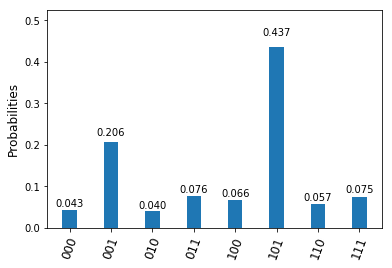

In [21]:
plot_histogram(counts)